<a href="https://colab.research.google.com/github/Onedory/UROP_colorize_method/blob/main/2.%20NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 사전 훈련된 VGG19 모델 불러오기

In [ ]:
# 라이브러리를 불러옵니다
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#이미지넷으로 사전 훈련된 VGG19 네트워크를 불러옵니다.
network = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 5s 0us/step


include_top=False :  전결합층(fully-connected layers)은 제외하고 오직 합성곱 계층(convolutional layers)과 풀링 계층(pooling layers)만 가져오겠다는 뜻입니다. 불러온 VGG19 네트워크로 분류를 할 건 아니므로, 마지막 전결합층은 빼준 것입니다.



weights='imagenet' : 이미지넷 데이터셋으로 사전 훈련된 모델을 불러오겠다는 말입니다.

In [ ]:
#VGG19 네트워크의 아키텍처를 살펴보시죠.
network.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

# 2. 이미지 불러온 뒤 전처리하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
content_image_path = '/content/drive/MyDrive/UROP/pink.png'
content_image = tf.keras.preprocessing.image.load_img(content_image_path)

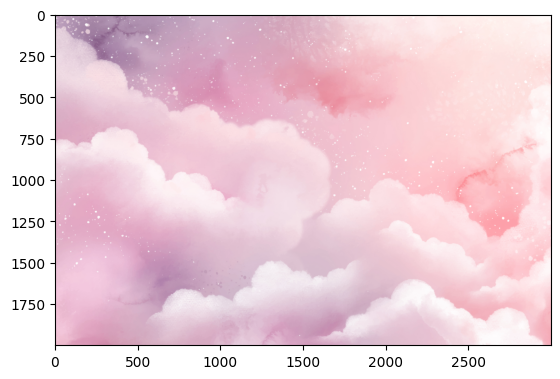

In [ ]:
plt.imshow(content_image);

In [ ]:
type(content_image) #불러온 이미지는 PIL타입이다.

PIL.JpegImagePlugin.JpegImageFile

**텐서플로로** 스타일 전이 작업을 하려면  PIL 타입을 넘파이 타입으로 바꿔줘야 합니다. img_to_array() 메서드로 구현할 수 있습니다.

In [ ]:
# Convert PIL image to numpy type to work with TensorFlow
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

type(content_image), content_image.shape, content_image.min(), content_image.max()

(numpy.ndarray, (2000, 3000, 3), 94.0, 255.0)

형상은 (183, 275,3)이다. 즉 가로,세로 크기가 각각 183, 275이고 채널수가 3개(RGB)이다. 이미지의 픽셀 최솟값,최댓값은 33과 247이다.

# **스타일 전이 작업을 위해서는 픽셀 범위를 정규화해줘야 한다. 모든 픽셀을 255로 나눠 0~1 사잇값으로 정규화힌다**

In [ ]:
# Normalizing
content_image = content_image / 255

content_image.min(), content_image.max()

(0.36862746, 1.0)

차원을 하나 더 더하자.

이미지를 딥러닝 모델에 전달하려면 배치 크기에 해당하는 차원이 하나 더 있어야 한다.

In [ ]:
content_image = content_image[tf.newaxis, :]

In [ ]:
#최종 형상 출력
content_image.shape

(1, 2000, 3000, 3)

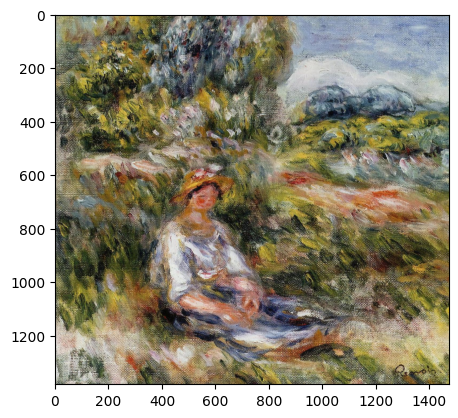

In [ ]:
#스타일 이미지를 불러와서 같은 전처리 작업
style_image_path = '/content/drive/MyDrive/UROP/Dataset/WikiArt/image_3.png'
style_image = tf.keras.preprocessing.image.load_img(style_image_path)

plt.imshow(style_image);

In [ ]:
#콘텐츠 이미지와 같은 전처리 작업
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image / 255
style_image = style_image[tf.newaxis, :]

style_image.shape

(1, 1382, 1472, 3)

# 3. 네트워크 만들기

지금까지 사전 훈련된 VGG19 네트워크를 불러왔고, 전처리한 이미지까지 준비했습니다. 이제는 본격적으로 스타일 전이 네트워크를 만들어보겠습니다.

 네트워크를 만들기 위해서 콘텐츠 레이어와 스타일 레이어를 정해야 합니다. **콘텐츠 레이어는 노이즈 이미지와 콘텐츠 이미지 사이의 손실을 구하는 레이어입니다. 스타일 레이어는 노이즈 이미지와 스타일 이미지 사이의 손실을 구하는 레이어고요**

 논문에서와 마찬가지로 콘텐츠 레이어는 한 개, 스타일 레이어는 5개로 정했습니다. 각 레이어의 이름을 리스트로 할당하고, 레이어의 개수도 변수로 지정했습니다

In [ ]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
[network.get_layer(name).output for name in style_layers]

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
network.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

# 스타일 전이를 위한 VGG 레이어를 정의해보죠. 먼저 VGG 네트워크를 불러온 뒤, 입력받은 레이어(콘텐츠 레이어와 스타일 레이어를 전달할 것임)마다 출력값을 내도록 정의합니다.

In [ ]:
def build_vgg_layers(layer_names):
    '''return output activation value'''
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    network = tf.keras.Model(inputs=[vgg.input], outputs=outputs)

    return network

In [ ]:
# extract image style
style_extractor = build_vgg_layers(style_layers)

In [ ]:
style_extractor.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv1')>]

In [ ]:
# 5 values with ReLU activation are applied
style_outputs = style_extractor(style_image)

style_outputs[0].shape, style_outputs[1].shape, style_outputs[2].shape, style_outputs[3].shape, style_outputs[4].shape

(TensorShape([1, 1382, 1472, 64]),
 TensorShape([1, 691, 736, 128]),
 TensorShape([1, 345, 368, 256]),
 TensorShape([1, 172, 184, 512]),
 TensorShape([1, 86, 92, 512]))

총 5가지 출력값이 반환됐네요. (배치 크기, 이미지 크기1, 이미지 크기2, 채널수)를 의미합니다. 앞쪽 레이어일수록 이미지 크기가 크고 채널수가 적습니다. 뒤로 갈수록 이미지 크기가 작아지고 채널수가 많아지고요.

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/einsum

# Loss between the style and the content image (see original paper, section 2.2)
def gram_matrix(layer_activation):
    result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    return result / num_locations  # Normalizing

다음으로 스타일 전이를 위한 모델 클래스를 만들어보겠습니다. __init__ 함수에는 build_vgg_lagyers()에 스타일 레이어와 콘텐츠 레이어 모두를 전달합니다.  이어서 call() 함수를 정의할 때는 입력값에 255를 곱합니다. 입력값이 0~1 사잇값이므로 이를 역정규화하기 위함이죠. 이 값을 VGG19 모델에 넣기 위해 전처리 작업을 합니다. vgg19.preprocess_input() 메서드로 구현할 수 있습니다. 최종 출력값 중 첫 5개는 스타일 레이어의 출력값이고, 나머지 하나는 콘텐츠 레이어의 출력값입니다. 이 출력값들을 딕셔너리로 저장해 반환합니다.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    '''Build a model that returns the style and content tensors.'''
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = build_vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False  # Because this network won't be trained

    def call(self, inputs):
        inputs = inputs * 255.0  # Denormalizing (Expects float input in [0,1])
        # Data is preprocessed and passed to the VGG (normalized from -127.50 to +127.50)
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

스타일 전이를 위한 extractor를 만들기 위해 앞서 만든 StyleContentModel 클래스에 스타일 레이어와 콘텐츠 레이어를 전달합니다. 여기서 style_layers와 content_layers는 각각 스타일 레이어 이름과 콘텐츠 레이어 이름이 담긴 리스트입니다.

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

이 extractor에 콘텐츠 이미지를 전달해 출력값을 result에 저장해보겠습니다.

In [ ]:
results = extractor(content_image)

In [ ]:
for key, value in results.items():
    print(key, value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


콘텐츠 레이어와 스타일 레이어의 이름이 출력됐네요. 스타일 타깃값과 콘텐츠 타깃값을 잡으려면 다음과 같이 key 값으로 지정해주면 됩니다.

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# 4. 모델 훈련

초기 노이즈 이미지는 new_image 변수에 할당하겠습니다. 옵티마이저는 Adam으로 하고 학습률은 0.07로 해보겠습니다. 콘텐츠 가중치와 스타일 가중치는 각각 1과 1,000으로 잡겠습니다. 에폭은 200번 돌리겠습니다.

스타일 손실, 콘텐츠 손실을 각각 구한 뒤, 두 손실의 합을 최종 손실로 잡습니다. 최종 손실 값이 작아지도록 모델을 훈련하며 new_image를 갱신하는 겁니다. 최종적으로 구한 new_image는 0~1 사잇값을 갖도록 클리핑까지 해주었습니다.

Epoch 25 | content loss: 321747.28125 | style loss: 755949436928.0 | total loss 755949764608.0


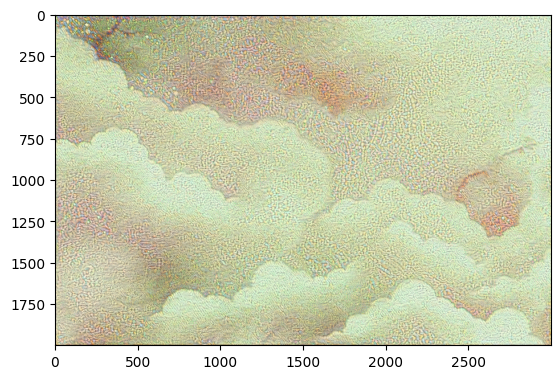

Epoch 50 | content loss: 324130.96875 | style loss: 175918661632.0 | total loss 175918989312.0


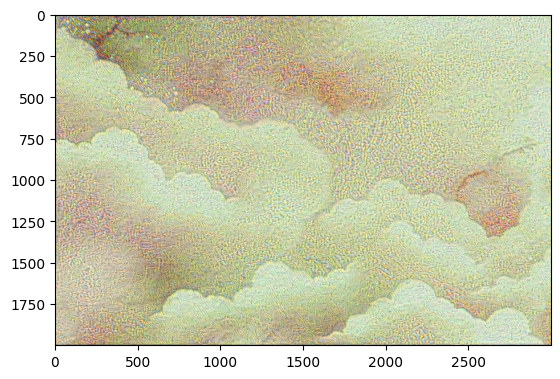

Epoch 75 | content loss: 326640.71875 | style loss: 75374297088.0 | total loss 75374624768.0


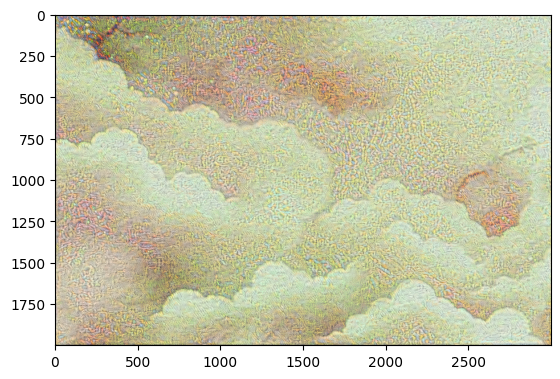

Epoch 100 | content loss: 327793.90625 | style loss: 49002569728.0 | total loss 49002897408.0


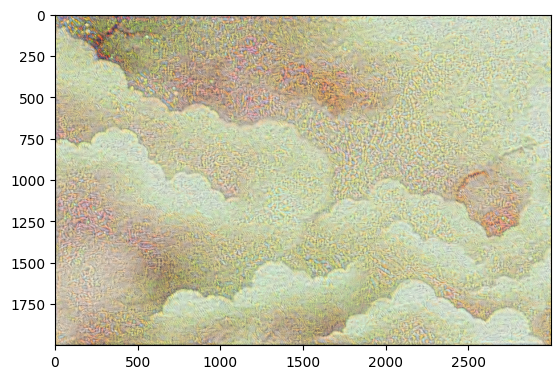

Epoch 125 | content loss: 328348.5625 | style loss: 38157332480.0 | total loss 38157660160.0


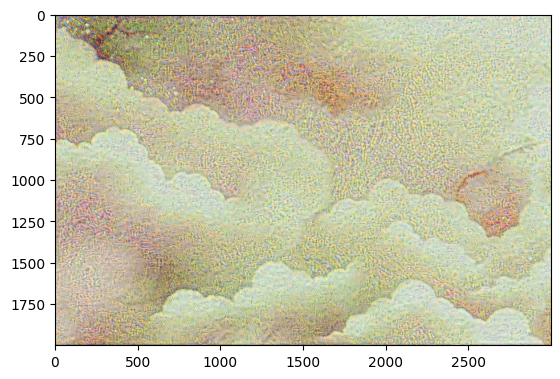

Epoch 150 | content loss: 328693.9375 | style loss: 32066041856.0 | total loss 32066369536.0


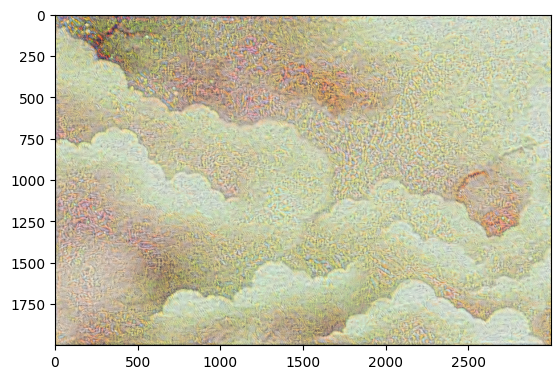

Epoch 175 | content loss: 328933.5 | style loss: 27993679872.0 | total loss 27994009600.0


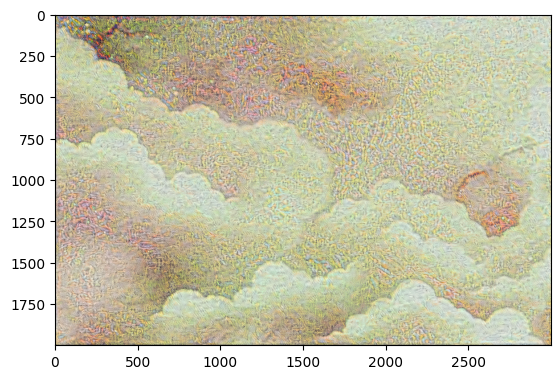

Epoch 200 | content loss: 329115.6875 | style loss: 24979322880.0 | total loss 24979652608.0


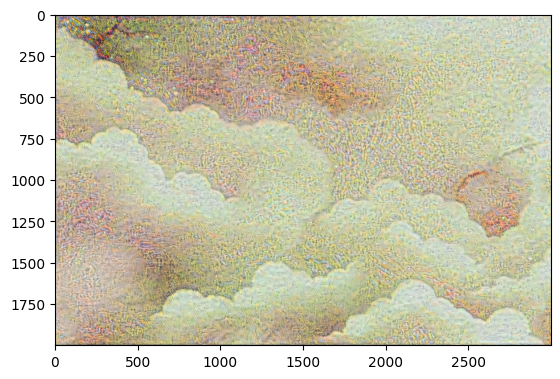

In [ ]:
new_image = tf.Variable(content_image)
optimizer = tf.optimizers.Adam(learning_rate=0.07)

content_weight = 1  # The greater the content weight, the greater the retention of the original image content
style_weight = 1000  # The greater the style weight, the more styles are preserved

num_epochs = 200
verbose = 25

for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        outputs = extractor(new_image)

        content_outputs = outputs['content']
        style_outputs = outputs['style']

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
        content_loss *= content_weight / num_content_layers

        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
        style_loss *= style_weight / num_style_layers

        total_loss = content_loss + style_loss

    gradient = tape.gradient(total_loss, new_image)
    optimizer.apply_gradients([(gradient, new_image)])

    new_image.assign(tf.clip_by_value(new_image, 0.0, 1.0))

    if (epoch + 1) % verbose == 0:
        print(f'Epoch {epoch + 1} | content loss: {content_loss} | style loss: {style_loss} | total loss {total_loss}')
        plt.imshow(tf.squeeze(new_image, axis=0))
        plt.show()

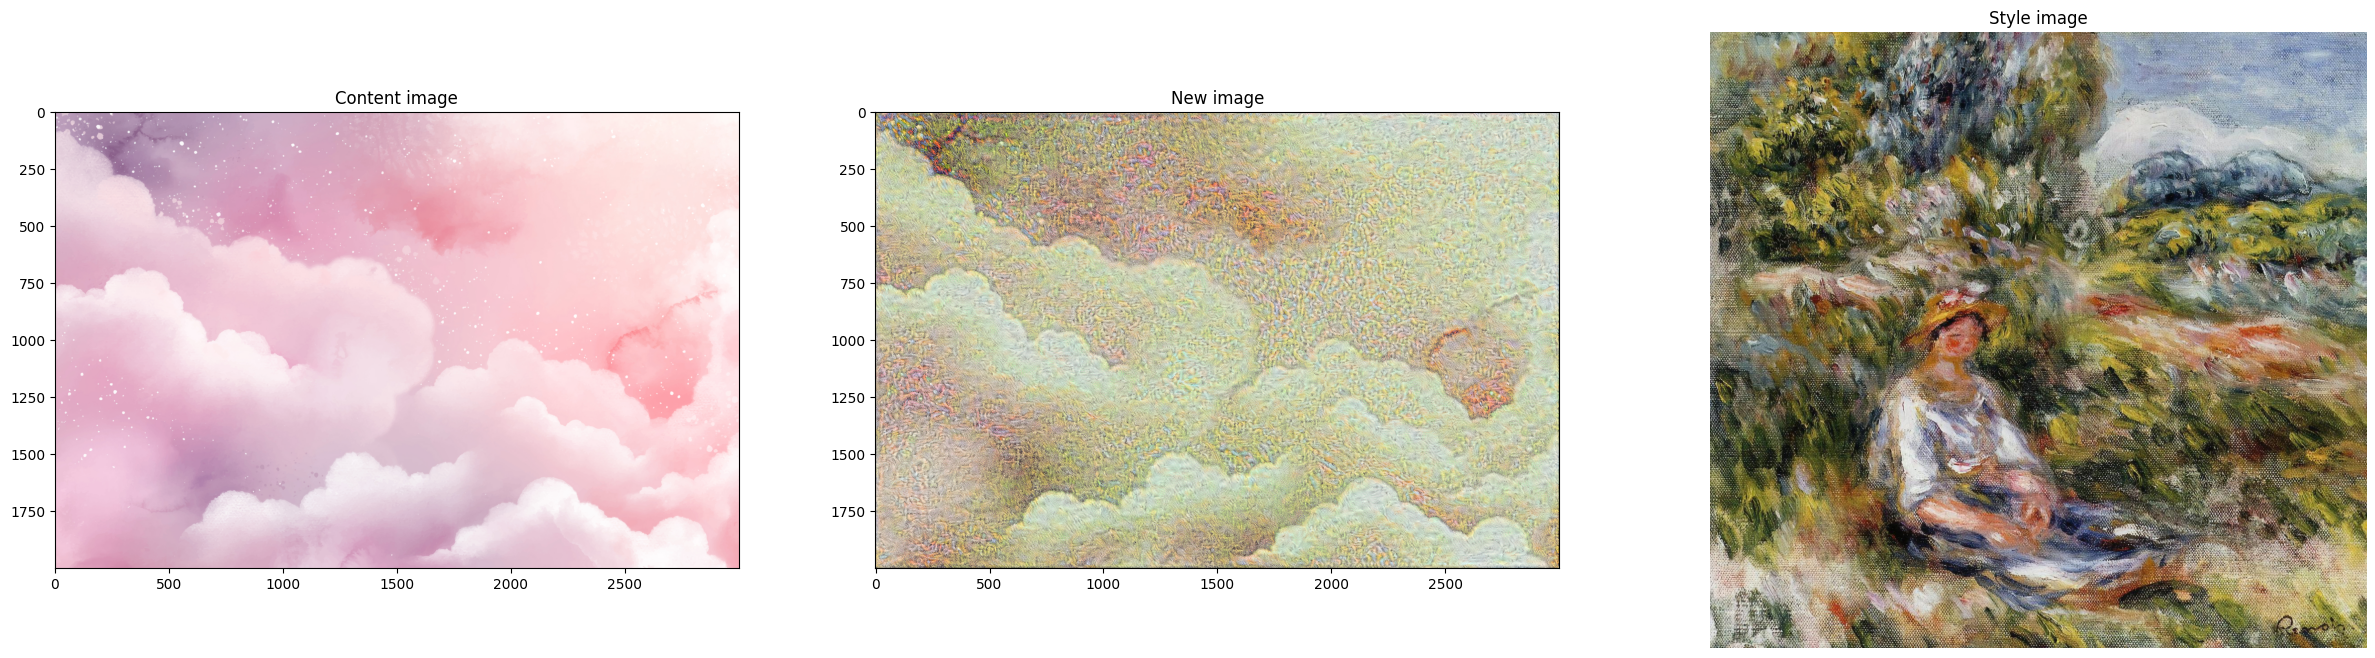

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 8))
ax1.imshow(tf.squeeze(content_image, axis=0))
ax1.set_title('Content image')
ax2.imshow(tf.squeeze(new_image, axis=0))
ax2.set_title('New image')
ax3.imshow(tf.squeeze(style_image, axis=0))
ax3.set_title('Style image')
plt.axis('off');